

## Dog Breed Recognition 

---

This notebook provides an algorithm for recognizing dog breeds from photos, or, if a person is present, the algorithm would identify the closest resemblance with a dog breed! 

The algorithms below rely on OpenCV's cascade classifier, and on pre-trained convolutional networks (CNNs).

Here are the steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Main Algorithm
* [Step 7](#step7): Algorithm Testing

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

The code cell below imports a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 8977 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the code below, the detector is used to find human faces in a sample image.

Number of faces detected: 1


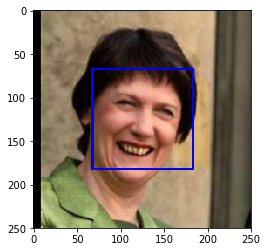

In [27]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[np.random.randint(0, len(human_files) - 1)])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector


In [28]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Testing the Human Face Detector



Percentage of human files with detected face is:  99.0 %
Percentage of dog files with detected face is:  11.0 %


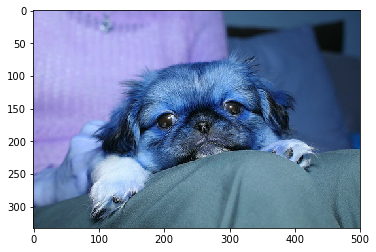

In [41]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

faces_in_human = [file for file in human_files_short if face_detector(file)]
print('Percentage of human files with detected face is: ', len(faces_in_human)/len(human_files_short)*100, '%')

faces_in_dogs = [file for file in dog_files_short if face_detector(file)]
print('Percentage of dog files with detected face is: ', len(faces_in_dogs)/len(dog_files_short)*100, '%')

# If it's a dog image, why does it have a human face? show an image sample:
if len(faces_in_dogs) > 0:
    img = cv2.imread(faces_in_dogs[np.random.randint(0, len(faces_in_dogs) - 1)])
    plt.imshow(img)
    plt.show()

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  

In [25]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data


In [30]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50


In [31]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector


In [32]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Testing the Dog Detector


Percentage of human files with detected dog is:  1.0 %
Percentage of dog files with detected dog is:  100.0 %


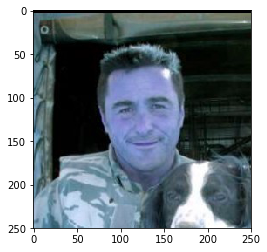

In [33]:
dogs_in_human = [file for file in human_files_short if dog_detector(file)]
print('Percentage of human files with detected dog is: ', len(dogs_in_human)/len(human_files_short)*100, '%')

dogs_in_dogImages = [file for file in dog_files_short if dog_detector(file)]
print('Percentage of dog files with detected dog is: ', len(dogs_in_dogImages)/len(dog_files_short)*100, '%')

# If it's a human image, why does it have a dog? show an image sample:
if len(dogs_in_human) > 0:
    img1 = cv2.imread(dogs_in_human[0])
    plt.imshow(img1)
    plt.show()

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


In [29]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:10<00:00, 83.41it/s]


In [34]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
__________

### Compile the Model

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model


In [36]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 212s - loss: 4.8845 - acc: 0.0097 - val_loss: 4.8685 - val_acc: 0.0108
Epoch 2/10
6680/6680 [==============================] - 207s - loss: 4.8641 - acc: 0.0117 - val_loss: 4.8525 - val_acc: 0.0168
Epoch 3/10
6680/6680 [==============================] - 207s - loss: 4.8238 - acc: 0.0180 - val_loss: 4.8129 - val_acc: 0.0240
Epoch 4/10
6680/6680 [==============================] - 207s - loss: 4.7814 - acc: 0.0216 - val_loss: 4.7896 - val_acc: 0.0251
Epoch 5/10
6680/6680 [==============================] - 207s - loss: 4.7477 - acc: 0.0232 - val_loss: 4.7671 - val_acc: 0.0180
Epoch 6/10
6680/6680 [==============================] - 206s - loss: 4.7180 - acc: 0

### Load the Model with the Best Validation Loss

In [37]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model


In [38]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.0670%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds


In [46]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [50]:
print(train_VGG16.shape)


(6680, 7, 7, 512)


### Model Architecture

Simple and minimal architecture, all the heavy lifting is done by the pre-trained model.

In [51]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [52]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [53]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 11.6747 - acc: 0.1379 - val_loss: 9.8136 - val_acc: 0.2347
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 8.9629 - acc: 0.3244 - val_loss: 8.7496 - val_acc: 0.3401
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.2225 - acc: 0.4037 - val_loss: 8.4739 - val_acc: 0.3605
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 7.8673 - acc: 0.4545 - val_loss: 8.3317 - val_acc: 0.3880
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 7.7318 - acc: 0.4780 - val_loss: 8.2818 - val_acc: 0.3928
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 7.6500 - acc: 0.4931 - va

### Load the Model with the Best Validation Loss

In [55]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model


In [56]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 52.2727%


### Predict Dog Breed with the Model

In [93]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

This time we'll use ResNet-50.

In [2]:
import numpy as np

bottleneck_features = np.load('bottleneck_features/DogResNet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [11]:
from keras.layers import Flatten, Dense
from keras.models import Sequential

myResNet50_model = Sequential()
myResNet50_model.add(Flatten(input_shape=train_ResNet50.shape[1:]))
myResNet50_model.add(Dense(133, activation='softmax'))

myResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [13]:
myResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model


In [14]:

from keras.callbacks import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

myResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 1.6281 - acc: 0.5990 - val_loss: 0.8009 - val_acc: 0.7449
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.4425 - acc: 0.8596 - val_loss: 0.7444 - val_acc: 0.7605
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.2607 - acc: 0.9156 - val_loss: 0.6610 - val_acc: 0.8072
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.1788 - acc: 0.9433 - val_loss: 0.6767 - val_acc: 0.7928
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.1226 - acc: 0.9605 - val_loss: 0.6710 - val_acc: 0.8132
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.0913 - acc: 0.9725 - val_loss: 0.7332 - val_acc: 0.8084
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.0618 - acc: 0.9820 - val_loss: 0.6699 - val_acc: 0.8240
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.0487 - ac

### Load the Model with the Best Validation Loss

In [15]:

myResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### Testing the Model


In [16]:

myResNet50_predictions = [np.argmax(myResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

test_accuracy = 100*np.sum(np.array(myResNet50_predictions)==np.argmax(test_targets, axis=1))/len(myResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.6220%


### Predict Dog Breed with the Model


In [17]:
from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    #print("*** input shape: ", bottleneck_feature.shape)
    # obtain predicted vector
    predicted_vector = myResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Final Algorithm


In [38]:

def identify_image(image_path):
    if dog_detector(image_path):
        print("Detected a dog of breed: ", ResNet50_predict_breed(image_path))
    elif face_detector(image_path):
        print("Detected a human resembling dog breed: ", ResNet50_predict_breed(image_path))
    else:
        print("Hmm! Couldn't detect humans or dogs.")
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.show()

---
<a id='step7'></a>
## Step 7: Testing the Algorithm

mysamples1\Australian terrier.jpg
*** input shape:  (1, 1, 1, 2048)
Detected a dog of breed:  Silky_terrier


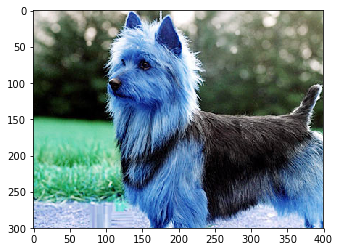

mysamples1\Border collie.jpg
*** input shape:  (1, 1, 1, 2048)
Detected a dog of breed:  Canaan_dog


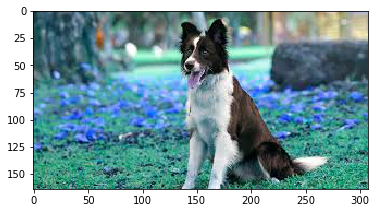

mysamples1\Brittany spaniel.jpg
*** input shape:  (1, 1, 1, 2048)
Detected a dog of breed:  Brittany


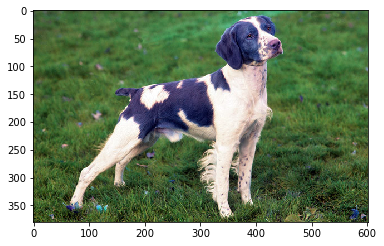

mysamples1\cat.jpg
Hmm! Couldn't detect humans or dogs.


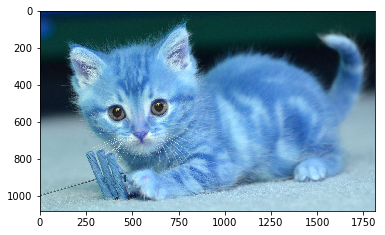

mysamples1\golden-retriever1.jpg
*** input shape:  (1, 1, 1, 2048)
Detected a dog of breed:  Labrador_retriever


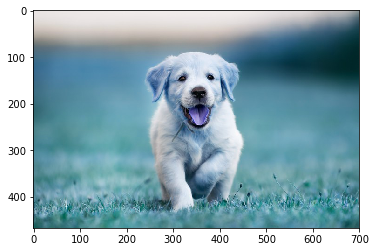

mysamples1\McKinnon.png
*** input shape:  (1, 1, 1, 2048)
Detected a human resembling dog breed:  Silky_terrier


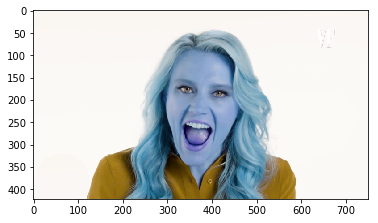

mysamples1\zuckerberg.jpg
*** input shape:  (1, 1, 1, 2048)
Detected a human resembling dog breed:  Silky_terrier


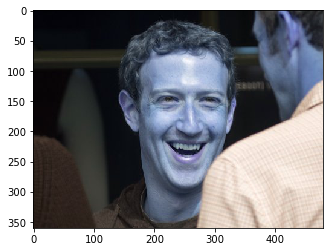

In [39]:
import glob
for file in glob.glob('mysamples1/*'):
        print(file)
        identify_image(file)
